In [4]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt 
import qutip
from scipy.linalg import sqrtm

from povm_clf_test import *

---
# Circuit Diagrams

## State preparation circuit

In [3]:
test = SingleQubitPOVM(bloch_vec=[0.7,0,0])
@qml.qnode(qml.device('default.qubit', wires=2))
def circ_test():
    test.state_prepared_on_circuit(wires=[0,1]) #요거 그림 그려보기!
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.7, 0, 0]
Output Bloch vector =  [7.00518230e-01 6.65558669e-04 2.89266589e-03]


In [4]:
diagram = qml.draw(circ_test)
print(diagram())

 0: ──Rot(1.45, 1.02, -0.85)───╭C──Rot(-1.96, 2.27, -6.07)──╭┤ ⟨Z ⊗ Z⟩ 
 1: ──Rot(-2.52, -1.6, -4.13)──╰X──Rot(3.28, -2.6, -1.53)───╰┤ ⟨Z ⊗ Z⟩ 



## n-element POVM circuit

In [ ]:
n = 3
devs = [qml.device('default.qubit', wires=n), qml.device('default.qubit', wires=n)]
wires = [0, 1, 2]
bloch_vecs = [[0,0,0.7], [0,0,-0.7]]
params = 2 * np.pi * np.random.random([(3 + 8 * 2)])


@qml.qnode(devs[0])
def circ_test1(params, wires):
    state_prepared(wires=[wires[0], wires[-1]])
    SingleQubitPOVM().first_U(params[:3], wire=wires[0])
    SingleQubitPOVM().two_element_povm(params[3:], wires=[wires[0],wires[1]])

    return qml.probs(wires=wires[1])

circ_test1(params=params, wires=wires)
print(circ_test1.draw())

---
# Pure-state Classifier

##  Two-element POVM

In [3]:
n = 2
dev = [qml.device('default.qubit', wires=n)] * n
wires = [0, 1]
bloch_vecs = [[1,0,0], [-1,0,0]]

In [4]:
classifier = POVM_clf(2, wires, bloch_vecs, dev)
Helstrom_bound = classifier.spectral_decomp()

In [5]:
cost_list = classifier.run_opt(steps=100)

Cost(init_params)    :  0.4760694
Cost after step    20:  0.1443643
Cost after step    40:  0.0021662
Cost after step    60:  0.0000320
Cost after step    80:  0.0000005
Cost after step   100:  0.0000000


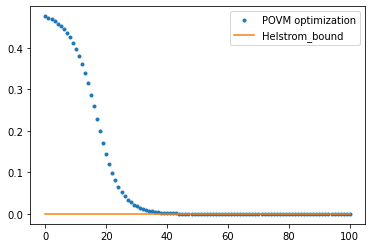

In [6]:
plt.plot(list(range(101)), cost_list, '.', label='POVM optimization')
plt.plot(list(range(101)), [Helstrom_bound]*101, '-', label="Helstrom_bound")
plt.legend()
plt.show()

In [10]:
K = classifier.kraus_op()
E = classifier.povm()
rho = classifier.density_matrices
K, E, rho

((tensor([[-2.03418257e-05+1.46183378e-08j,
            2.03418259e-05-1.46184923e-08j],
          [ 7.07106597e-01+5.08156561e-04j,
            7.07106591e-01+5.08151194e-04j]], requires_grad=True),
  tensor([[ 7.07106595e-01-5.08151197e-04j,
           -7.07106601e-01+5.08156565e-04j],
          [ 8.10527988e-05+5.82479526e-08j,
            8.10527981e-05+5.82473373e-08j]], requires_grad=True)),
 (tensor([[0.5       +0.00000000e+00j, 0.49999999-3.79276262e-09j],
          [0.49999999+3.79276262e-09j, 0.49999999+0.00000000e+00j]], requires_grad=True),
  tensor([[ 0.5       +0.00000000e+00j, -0.49999999+3.79276262e-09j],
          [-0.49999999-3.79276262e-09j,  0.50000001+0.00000000e+00j]], requires_grad=True)),
 [tensor([[0.5+0.j, 0.5+0.j],
          [0.5+0.j, 0.5+0.j]], requires_grad=True),
  tensor([[ 0.5+0.j, -0.5+0.j],
          [-0.5+0.j,  0.5+0.j]], requires_grad=True)])

## Three-element POVM

In [81]:
n = 3
dev = [qml.device('default.qubit', wires=n)] * n
wires = [0, 1, 2]


state_vecs = [[1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)], \
                [1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)]]
bloch_vecs = [state_2_bloch(state_vecs[i]) for i in range(n)

In [82]:
classifier = POVM_clf(n, wires, bloch_vecs, dev)
#Helstrom_bound = classifier.spectral_decomp()

In [83]:
steps = 300
cost_list = classifier.run_opt(steps)

Cost(init_params)    :  0.7080831
Cost after step    20:  0.6506864
Cost after step    40:  0.5334323
Cost after step    60:  0.4012811
Cost after step    80:  0.3520046
Cost after step   100:  0.3387344
Cost after step   120:  0.3351352
Cost after step   140:  0.3340359
Cost after step   160:  0.3336414
Cost after step   180:  0.3334793
Cost after step   200:  0.3334058
Cost after step   220:  0.3333703
Cost after step   240:  0.3333524
Cost after step   260:  0.3333432
Cost after step   280:  0.3333385
Cost after step   300:  0.3333360


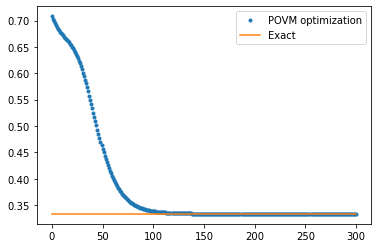

In [84]:
plt.plot(list(range(steps+1)), cost_list, '.', label='POVM optimization')
pgm, cost_pgm = classifier.sq_rt_m()
plt.plot(list(range(steps+1)), [cost_pgm]*(steps+1), '-', label="Exact")
plt.legend()
plt.show()

In [85]:
K = classifier.kraus_op()
E = classifier.povm()
rho = classifier.density_matrices
E

(tensor([[ 0.3332859 +0.j        , -0.16846876+0.28757226j],
         [-0.16846876-0.28757226j,  0.33328601+0.j        ]], requires_grad=True),
 tensor([[0.33496495+0.j        , 0.33496433-0.00062852j],
         [0.33496433+0.00062852j, 0.33496489+0.j        ]], requires_grad=True),
 tensor([[ 0.33174915+0.j        , -0.16649557-0.28694374j],
         [-0.16649557+0.28694374j,  0.3317491 +0.j        ]], requires_grad=True))

In [86]:
[np.trace(np.dot(E[i],rho[i])) for i in range(3)]

[(0.16847545244759105+0j), (0.6699292431652624+0j), (0.16649634209141412+0j)]

In [6]:
#PGM
classifier.sq_rt_m()

([tensor([[ 0.33333333-2.13662521e-17j, -0.16666667-2.88675135e-01j],
          [-0.16666667+2.88675135e-01j,  0.33333333-2.13662521e-17j]], requires_grad=True),
  tensor([[0.33333333+0.j, 0.33333333+0.j],
          [0.33333333+0.j, 0.33333333+0.j]], requires_grad=True),
  tensor([[ 0.33333333+2.13662521e-17j, -0.16666667+2.88675135e-01j],
          [-0.16666667-2.88675135e-01j,  0.33333333+2.13662521e-17j]], requires_grad=True)],
 0.3333333333333335)

Bloch Sphere visualization for both initial qubit and measurment direction

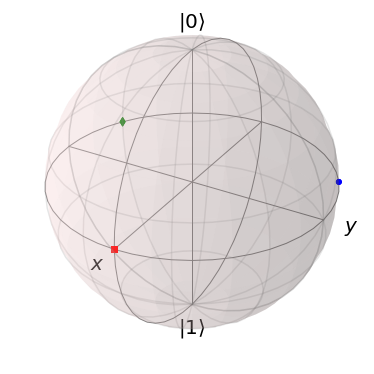

In [17]:
bloch3 = qutip.Bloch()
bloch3.add_points(bloch_vecs[0])
bloch3.add_points(bloch_vecs[1])
bloch3.add_points(bloch_vecs[2])
#bloch3.save('bs_3')
bloch3.show()

---
# Mixed-state Classifier

## Two-element POVM

In [8]:
n = 2
n_qubit = n + 1
devs = [qml.device('default.qubit', wires=n_qubit)] * n
wires = [0, 1, 2]
bloch_vecs = [[0.2,0,0], [-0.2,0,0]]

In [9]:
classifier = POVM_clf(2, wires, bloch_vecs, devs)
Helstrom_bound_exact = classifier.spectral_decomp()
Helstrom_bound_noisy = classifier.spectral_decomp(types='noisy')

* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.2, 0, 0]
Output Bloch vector =  [0.19820978 0.0006546  0.00154326]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [-0.2, 0, 0]
Output Bloch vector =  [-0.20001478 -0.00167471 -0.00026973]


In [10]:
steps=400
cost_list = classifier.run_opt(steps)

Cost(init_params)    :  0.5000960
Cost after step    20:  0.4998963
Cost after step    40:  0.4995666
Cost after step    60:  0.4986857
Cost after step    80:  0.4961913
Cost after step   100:  0.4895065
Cost after step   120:  0.4743087
Cost after step   140:  0.4498586
Cost after step   160:  0.4262387
Cost after step   180:  0.4120539
Cost after step   200:  0.4054791
Cost after step   220:  0.4026407
Cost after step   240:  0.4014120
Cost after step   260:  0.4008727
Cost after step   280:  0.4006336
Cost after step   300:  0.4005271
Cost after step   320:  0.4004796
Cost after step   340:  0.4004583
Cost after step   360:  0.4004488
Cost after step   380:  0.4004446
Cost after step   400:  0.4004427


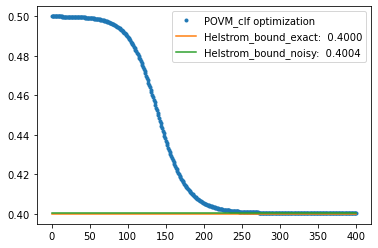

In [11]:
plt.plot(list(range(steps+1)), cost_list, '.', label='POVM_clf optimization')
plt.plot(list(range(steps+1)), [Helstrom_bound_exact]*(steps+1), '-', label="Helstrom_bound_exact: {: .4f}".format(Helstrom_bound_exact))
plt.plot(list(range(steps+1)), [Helstrom_bound_noisy]*(steps+1), '-', label="Helstrom_bound_noisy: {: .4f}".format(Helstrom_bound_noisy))
plt.legend()
plt.show()

In [12]:
K = classifier.kraus_op()
E = classifier.povm()
rho = classifier.density_matrices

In [13]:
1-(1/2)*sum([np.trace(np.dot(E[i], rho[i])) for i in range(2)])

(0.40000430209859195+0j)

In [14]:
E

(tensor([[0.50228751+0.j       , 0.49997849-0.0029226j],
         [0.49997849+0.0029226j, 0.49770757+0.j       ]], requires_grad=True),
 tensor([[ 0.49771249+0.j       , -0.49997849+0.0029226j],
         [-0.49997849-0.0029226j,  0.50229243+0.j       ]], requires_grad=True))

## Three-element POVM

In [38]:
n = 3
n_qubit = n + 1
devs = [qml.device('default.qubit', wires=n_qubit)] * n
wires = [0, 1, 2, 3]

state_vecs = [[1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)], \
                [1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)]]
bloch_vecs = [state_2_bloch(state_vecs[i]) for i in range(n)]
bloch_vecs = [[0.7 * bloch_vecs[n][i] for i in range(3)] for n in range(n)]

In [39]:
classifier = POVM_clf(3, wires, bloch_vecs, devs)
#Helstrom_bound_exact = classifier.spectral_decomp()
#Helstrom_bound_noisy = classifier.spectral_decomp(types='noisy')

* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [-0.3499999999999998, 0.6062177826491071, -1.1256858547736456e-16]
Output Bloch vector =  [-0.3486154   0.6061899  -0.00239247]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.7, 0.0, -1.1256858547736456e-16]
Output Bloch vector =  [ 0.70117007 -0.00117203  0.00076142]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [-0.3499999999999998, -0.6062177826491071, -1.1256858547736456e-16]
Output Bloch vector =  [-0.34949757 -0.60564331 -0.0031617 ]


In [51]:
steps=600
cost_list = classifier.run_opt(steps)

Cost(init_params)    :  0.4333995
Cost after step    20:  0.4333859
Cost after step    40:  0.4333780
Cost after step    60:  0.4333732
Cost after step    80:  0.4333702
Cost after step   100:  0.4333684
Cost after step   120:  0.4333672
Cost after step   140:  0.4333665
Cost after step   160:  0.4333660
Cost after step   180:  0.4333658
Cost after step   200:  0.4333656
Cost after step   220:  0.4333655
Cost after step   240:  0.4333654
Cost after step   260:  0.4333653
Cost after step   280:  0.4333653
Cost after step   300:  0.4333653
Cost after step   320:  0.4333653
Cost after step   340:  0.4333653
Cost after step   360:  0.4333653
Cost after step   380:  0.4333653
Cost after step   400:  0.4333653
Cost after step   420:  0.4333653
Cost after step   440:  0.4333653
Cost after step   460:  0.4333653
Cost after step   480:  0.4333653
Cost after step   500:  0.4333653
Cost after step   520:  0.4333653
Cost after step   540:  0.4333653
Cost after step   560:  0.4333653
Cost after ste

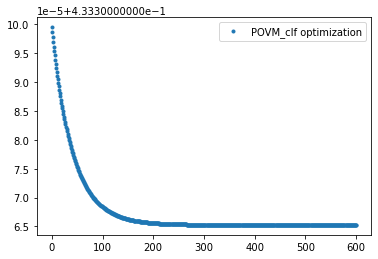

In [52]:
plt.plot(list(range(steps+1)), cost_list, '.', label='POVM_clf optimization')
#plt.plot(list(range(steps+1)), [Helstrom_bound_exact]*(steps+1), '-', label="Helstrom_bound_exact: {: .4f}".format(Helstrom_bound_exact))
#plt.plot(list(range(steps+1)), [Helstrom_bound_noisy]*(steps+1), '-', label="Helstrom_bound_noisy: {: .4f}".format(Helstrom_bound_noisy))
plt.legend()
plt.show()

In [53]:
K = classifier.kraus_op()
E = classifier.povm()
rho = classifier.density_matrices

In [54]:
E, 1-(1/3)*sum([np.trace(np.dot(E[i], rho[i])) for i in range(3)])

((tensor([[ 0.33302119+0.j        , -0.16667687-0.28874637j],
          [-0.16667687+0.28874637j,  0.33377949+0.j        ]], requires_grad=True),
  tensor([[0.33470387+0.j        , 0.33357764+0.00056994j],
          [0.33357764-0.00056994j, 0.33245618+0.j        ]], requires_grad=True),
  tensor([[ 0.33227494+0.j        , -0.16690077+0.28817643j],
          [-0.16690077-0.28817643j,  0.33376433+0.j        ]], requires_grad=True)),
 (0.4333342051151585+0j))

In [55]:
pgm, cost_pgm = classifier.sq_rt_m()
pgm, cost_pgm

([tensor([[ 0.33333333-1.12172823e-17j, -0.11666667-2.02072594e-01j],
          [-0.11666667+2.02072594e-01j,  0.33333333-1.12172823e-17j]], requires_grad=True),
  tensor([[0.33333333+0.j, 0.23333333+0.j],
          [0.23333333+0.j, 0.33333333+0.j]], requires_grad=True),
  tensor([[ 0.33333333+1.12172823e-17j, -0.11666667+2.02072594e-01j],
          [-0.11666667-2.02072594e-01j,  0.33333333+1.12172823e-17j]], requires_grad=True)],
 0.5033333333333334)

$$
\text{Tr}[\hat{\rho}_i\hat{E}_i]
$$

In [61]:
[np.real(np.trace(np.dot(rho[i], pgm[i]))) for i in range(3)]

[0.4966666666666666, 0.4966666666666666, 0.4966666666666666]

In [62]:
[np.real(np.trace(np.dot(rho[i], E[i]))) for i in range(3)]

[0.5667804282755329, 0.5670843747270415, 0.5661325816519499]

In [67]:
np.dot(rho[0], rho[1])

tensor([[0.18875-0.10608811j, 0.0875 -0.15155445j],
        [0.0875 +0.15155445j, 0.18875+0.10608811j]], requires_grad=True)

In [65]:
i, j = 0, 1
np.dot(np.dot(pgm[i], rho[i] - rho[j]), pgm[j])

tensor([[ 5.59737442e-18+5.80039465e-19j,
         -2.97500000e-02-1.71761705e-02j],
        [-2.97500000e-02+1.71761705e-02j,
          9.29811783e-18-2.16076401e-18j]], requires_grad=True)

In [72]:
i, j = 1, 2
np.dot(np.dot(E[i], rho[i] - rho[j]), E[j])

tensor([[-0.00043039-9.99921834e-06j,  0.00022485-3.68245770e-04j],
        [-0.00042896-9.23270331e-06j,  0.00022347-3.67389568e-04j]], requires_grad=True)

---
# For various purities $\mathcal{P}$,

$\hat{\rho} = \frac{1}{2}(I+\vec{a}\cdot\hat{\sigma})$ <br>
$
\mathcal{P} = Tr[\hat{\rho}^2] = \frac{1}{2}(1+|\vec{a}|^2) \Longrightarrow
|\vec{a}| = \sqrt{2\mathcal{P}-1}
$ 

## Case 1
$\vec{a}_1 = (\sqrt{2\mathcal{P}-1}, 0, 0)$  
$\vec{a}_2 = (-\sqrt{2\mathcal{P}-1}, 0, 0)$

In [ ]:
n_qubit = 3
wires = [0, 1, 2]
n_outcome = 2
devs = [qml.device('default.qubit', wires=n_qubit)] * n_outcome

cost_list, Hbe_list, Hbn_list = [], [], []
ampltd_abs = [1, 0.7, 0.4, 0.1]
#Pure state


#Mixed state
steps = [100, 150, 200, 400]
for i, a in enumerate(ampltd_abs):
    
    bloch_vecs = [[a,0,0], [(-1)*a,0,0]]
    if a == 1:
        classifier =POVM_clf(2, wires[:2], bloch_vecs, devs[:2])
        cost_list.append(classifier.run_opt(steps[i]))
        Hbe_list.append(classifier.spectral_decomp())
        Hbn_list.append(classifier.spectral_decomp())

    else:
        classifier = POVM_clf(2, wires, bloch_vecs, devs)
        Hbe_list.append(classifier.spectral_decomp())
        Hbn_list.append(classifier.spectral_decomp(types='noisy'))

        cost_list.append(classifier.run_opt(steps[i]))

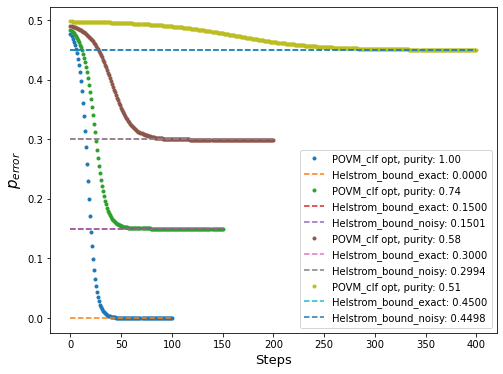

In [14]:
plt.figure(figsize=(8,6))
for i in range(len(cost_list)):
    plt.plot(list(range(steps[i]+1)), cost_list[i], '.', label="POVM_clf opt, purity:{: .2f}".format((ampltd_abs[i]**2+1)/2))
    plt.plot(list(range(steps[i]+1)), [Hbe_list[i]]*(steps[i]+1), '--', label="Helstrom_bound_exact: {:.4f}".format(Hbe_list[i]))
    if i !=0:
        plt.plot(list(range(steps[i]+1)), [Hbe_list[i]]*(steps[i]+1), '--', label="Helstrom_bound_noisy: {:.4f}".format(Hbn_list[i]))

plt.xlabel('Steps', fontsize=13)
plt.ylabel(r'$p_{error}$', fontsize=15)
plt.legend()
plt.savefig('result1.png', bbox_inches='tight', transparent=True)
plt.show()

## Case 2
$\vec{a}_1 = (\sqrt{2\mathcal{P}-1}, 0, 0)$  
$\vec{a}_2 = (0, 0, \sqrt{2\mathcal{P}-1})$

In [15]:
n_qubit = 3
wires = [0, 1, 2]
n_outcome = 2
devs = [qml.device('default.qubit', wires=n_qubit)] * n_outcome

cost_list, Hbe_list, Hbn_list = [], [], []
purities = [1, 0.85, 0.7, 0.55]


steps = [130, 170, 250, 500]
for i, p in enumerate(purities):
    
    bloch_vecs = [[np.sqrt(2*p-1),0,0], [0,0,np.sqrt(2*p-1)]]
    if p == 1:
        classifier =POVM_clf(2, wires[:2], bloch_vecs, devs[:2])
        cost_list.append(classifier.run_opt(steps[i]))
        Hbe_list.append(classifier.spectral_decomp())
        Hbn_list.append(classifier.spectral_decomp())

    else:
        classifier = POVM_clf(2, wires, bloch_vecs, devs)
        Hbe_list.append(classifier.spectral_decomp())
        Hbn_list.append(classifier.spectral_decomp(types='noisy'))

        cost_list.append(classifier.run_opt(steps[i]))

Cost(init_params)    :  0.5131265
Cost after step    20:  0.2264332
Cost after step    40:  0.1508853
Cost after step    60:  0.1466824
Cost after step    80:  0.1464592
Cost after step   100:  0.1464473
Cost after step   120:  0.1464466
* Optimizing for preparing a mixed state ......

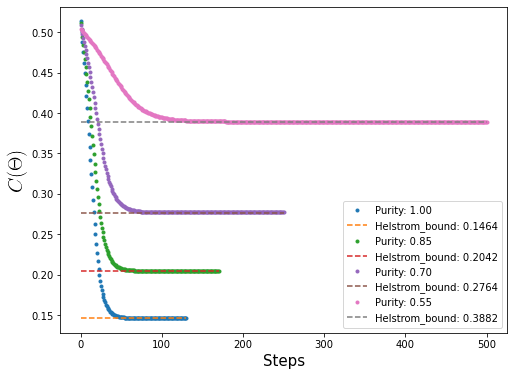

In [14]:
plt.figure(figsize=(8,6))
for i in range(len(cost_list)):
    plt.plot(list(range(steps[i]+1)), cost_list[i], '.', label="Purity:{: .2f}".format((purities[i])))
    plt.plot(list(range(steps[i]+1)), [Hbe_list[i]]*(steps[i]+1), '--', label="Helstrom_bound: {:.4f}".format(Hbe_list[i]))
    #if i !=0:
    #    plt.plot(list(range(steps[i]+1)), [Hbe_list[i]]*(steps[i]+1), '--', label="Helstrom_bound, "+r"$\rho_{noisy}$"+": {:.4f}".format(Hbn_list[i]))

plt.xlabel('Steps', fontsize=15)
plt.ylabel(r'$C(\Theta)$', fontsize=20, usetex=True)
plt.legend()
plt.savefig('result2.png', bbox_inches='tight', transparent=True)
plt.show()

## Case 3
$|\psi_0\rangle = \left(|0\rangle + e^{2\pi i /3}|1\rangle\right)/\sqrt{2}$ ===> $\vec{a}_0=\sqrt{2\mathcal{P}-1}(-1/2, \sqrt{3}/2, 0)$<br>
$|\psi_1\rangle = \left(|0\rangle+|1\rangle\right)/\sqrt{2}$       ========> $\vec{a}_1 = \sqrt{2\mathcal{P}-1}(1,0,0) $ <br>
$|\psi_2\rangle = \left(|0\rangle + e^{-2\pi i /3}|1\rangle\right)/\sqrt{2}$ ===> $\vec{a}_2 = \sqrt{2\mathcal{P}-1}(-1/2, -\sqrt{3}/2, 0)$

In [34]:
n_qubit = 4
wires = [0, 1, 2, 3]
n_outcome = 3
devs = [qml.device('default.qubit', wires=n_qubit)] * n_outcome

cost_list = []
cost_pgm_list = []
purities = [1, 0.85, 0.7, 0.55]
steps = [300, 700, 700, 700]

for i, p in enumerate(purities):    
    state_vecs = [[1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)]]
    bloch_vecs = [state_2_bloch(state_vecs[i]) for i in range(3)]
    bloch_vecs = [[np.sqrt(2*p-1) * bloch_vecs[n][i] for i in range(3)] for n in range(3)]

    if p == 1:
        classifier =POVM_clf(3, wires[:3], bloch_vecs, devs)
        cost_list.append(classifier.run_opt(steps[i]))

    else:
        classifier = POVM_clf(3, wires, bloch_vecs, devs)
        cost_list.append(classifier.run_opt(steps[i]))
    
    pgm, cost_pgm = classifier.sq_rt_m()
    cost_pgm_list.append(cost_pgm)

Cost(init_params)    :  0.7080831
Cost after step    20:  0.6506864
Cost after step    40:  0.5334323
Cost after step    60:  0.4012811
Cost after step    80:  0.3520046
Cost after step   100:  0.3387344
Cost after step   120:  0.3351352
Cost after step   140:  0.3340359
Cost after step   160:  0.3336414
Cost after step   180:  0.3334793
Cost after step   200:  0.3334058
Cost after step   220:  0.3333703
Cost after step   240:  0.3333524
Cost after step   260:  0.3333432
Cost after step   280:  0.3333385
Cost after step   300:  0.3333360
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [-0.4183300132670376, 0.7245688373094721, -1.3454519387485027e-16]
Output Bloch vector =  [-0.41899513  0.72457413 -0.00076244]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.8366600265340756, 0.0, -1.3454519387485027e-16]
Output Bloch vector =  [8.35795789e-01 4.77741450e-04 3.30869028e-03]
* Optimizing for 

In [37]:
cost_pgm_list

[0.3333333333333335,
 0.43333333333333335,
 0.5333333333333334,
 0.6333333333333332]

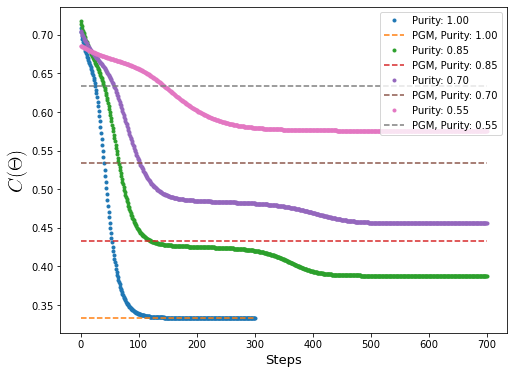

In [12]:
plt.figure(figsize=(8,6))
for i in range(len(cost_list)):
    plt.plot(list(range(steps[i]+1)), cost_list[i], '.', label="Purity:{: .2f}".format((purities[i])))
    #cost_pgm
    plt.plot(list(range(steps[i]+1)), [cost_pgm_list[i]]*(steps[i]+1), '--', label="PGM, Purity:{: .2f}".format((purities[i])))


plt.xlabel('Steps', fontsize=13)
plt.ylabel(r'$C(\Theta)$', fontsize=20, usetex=True)
plt.legend()
plt.savefig('result3.png', bbox_inches='tight', transparent=True)
plt.show()

In [4]:
[cost_list[i][-1] for i in range(4)]

[0.333336019989774,
 0.38811440103983674,
 0.4557114445909325,
 0.5751731372929737]

`seed(9)` [0.333336019989774,
 0.38811440103983674,
 0.4557114445909325,
 0.5751731372929737]

`seed(10)`
[0.3334029406865143,
 0.40208094829335383,
 0.45379789753879407,
 0.5611921005937575]

그래프 조금 더 다듬기

## Case 4
$\vec{a}_0=\sqrt{2\mathcal{P}-1}(1, 0, 0)$<br>
$\vec{a}_1 = \sqrt{2\mathcal{P}-1}(0, 1, 0) $ <br>
$\vec{a}_2 = \sqrt{2\mathcal{P}-1}(0, 0, 1)$

In [73]:
n_qubit = 4
wires = [0, 1, 2, 3]
n_outcome = 3
devs = [qml.device('default.qubit', wires=n_qubit)] * n_outcome

cost_list = []
cost_pgm_list = []
purities = [1, 0.85, 0.7, 0.55]
steps = [300, 700, 700, 700]

for i, p in enumerate(purities):    
    bloch_vecs = [[1,0,0], [0,1,0], [0, 0, 1]]
    bloch_vecs = [[np.sqrt(2*p-1) * bloch_vecs[n][i] for i in range(3)] for n in range(3)]

    if p == 1:
        classifier =POVM_clf(3, wires[:3], bloch_vecs, devs)
        cost_list.append(classifier.run_opt(steps[i]))

    else:
        classifier = POVM_clf(3, wires, bloch_vecs, devs)
        cost_list.append(classifier.run_opt(steps[i]))
    
    pgm, cost_pgm = classifier.sq_rt_m()
    cost_pgm_list.append(cost_pgm)

Cost(init_params)    :  0.6806341
Cost after step    20:  0.5717313
Cost after step    40:  0.4399949
Cost after step    60:  0.4080400
Cost after step    80:  0.3996520
Cost after step   100:  0.3965569
Cost after step   120:  0.3953304
Cost after step   140:  0.3948449
Cost after step   160:  0.3946513
Cost after step   180:  0.3945715
Cost after step   200:  0.3945365
Cost after step   220:  0.3945201
Cost after step   240:  0.3945117
Cost after step   260:  0.3945072
Cost after step   280:  0.3945047
Cost after step   300:  0.3945033
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.8366600265340756, 0.0, 0.0]
Output Bloch vector =  [ 0.83727665 -0.0027127  -0.00252595]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.0, 0.8366600265340756, 0.0]
Output Bloch vector =  [-7.07989662e-04  8.37538164e-01  1.56406598e-03]
* Optimizing for preparing a mixed state .............................

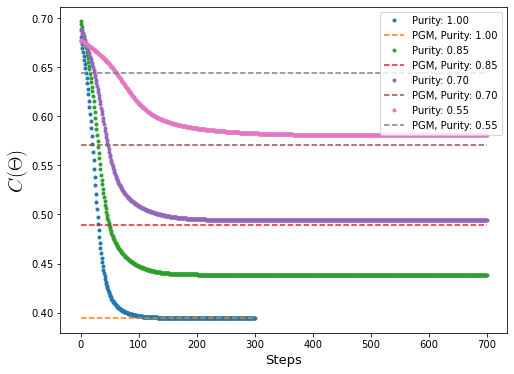

In [74]:
plt.figure(figsize=(8,6))
for i in range(len(cost_list)):
    plt.plot(list(range(steps[i]+1)), cost_list[i], '.', label="Purity:{: .2f}".format((purities[i])))
    #cost_pgm
    plt.plot(list(range(steps[i]+1)), [cost_pgm_list[i]]*(steps[i]+1), '--', label="PGM, Purity:{: .2f}".format((purities[i])))


plt.xlabel('Steps', fontsize=13)
plt.ylabel(r'$C(\Theta)$', fontsize=20, usetex=True)
plt.legend()
#plt.savefig('result4.png', bbox_inches='tight', transparent=True)
plt.show()

In [79]:
E = classifier.povm()
rho = classifier.density_matrices

In [80]:
np.trace(np.dot(E[0],rho[0]))

(0.4218252531205732+0j)

---
---
---
# Test

In [36]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt 

from povm_clf_test import *

In [37]:
n = 3
dev = [qml.device('default.qubit', wires=n)] * n#, qml.device('default.qubit', wires=n), qml.device('default.qubit', wires=n)] 
wires = [0, 1, 2]

state_vecs = [[1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)], \
                [1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)]]
bloch_vecs = [state_2_bloch(state_vecs[i]) for i in range(n)] 

In [38]:
np.random.seed(2)
params = 4 * np.pi * np.random.random([19])
params

tensor([ 5.47887353,  0.32579864,  6.90726241,  5.47042252,  5.2824976 ,
         4.15110979,  2.57169058,  7.78198847,  3.76557169,  3.35305043,
         7.80539794,  6.64939566,  1.69118147,  6.45381301,  2.31773971,
         9.86881252, 10.73137002,  6.21076327, 10.63820537], requires_grad=True)

In [39]:
params_opt = np.array([2.07716568, 7.85397763, 0.5236459 , 3.14159269, 1.23291917,
        1.59793933, 7.49892272, 2.84015056, 1.0471506 , 1.59700472,
        4.39604675, 6.28317501, 3.14158859, 8.04758825, 6.07043459,
        6.34899187, 4.86183644, 9.97314239, 7.28854747])
classifier = POVM_clf(n, wires, bloch_vecs, dev)
classifier.cost_fn(params), classifier.cost_fn(params_opt)

(0.6590201492131856, 0.4658705746335089)

In [42]:
classifier.povm_params

tensor([0.13036546, 6.30674213, 6.23007094, 1.68175146, 1.78582057,
        2.74648932, 5.2591289 , 3.11773123, 1.05632473, 4.34166396], requires_grad=True)

In [43]:
qnodes = qml.QNodeCollection()
for i in range(3):
    povm_circ = SingleQubitPOVM(n=3, bloch_vec = bloch_vecs[i])
    qnode = povm_circ(wires=wires, dev=dev[i])
    qnodes.append(qnode)
probs_povm = qnodes(params)
probs_povm

array([[8.18281620e-01, 0.00000000e+00, 1.00309875e-02, 1.71687392e-01],
       [7.98603265e-01, 7.70371978e-34, 1.62819042e-02, 1.85114830e-01],
       [8.03528796e-01, 7.73381243e-34, 8.09517569e-03, 1.88376028e-01]])

In [44]:
print(probs_povm[0][0], probs_povm[1][2], probs_povm[2][3])

0.8182816203882222 0.016281904151902307 0.18837602782031881


In [ ]:
probs_povm[0][0] + q[1] * probs_povm[1][2] + q[2] * probs_povm[2][3]

---
---
---